In [2]:
import csv
import os
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import country_converter as cc

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [30]:
data = pd.read_csv("../data/processed/drought-agtfp-gdp-data.csv")
print(len(data))

11387


# Drought - Ag. TfP

## remove missing rows

In [31]:
european_countries = set()
for country in set(data.country):
    if cc.convert(names=[country], to="Continent") == "Europe":
        european_countries.add(country)
indices_to_drop = []
no_nan_cols = ["ln_TFP_change"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
    elif row.country not in european_countries:
        indices_to_drop.append(index)
data = data.drop(indices_to_drop)
data = data.reset_index()
print(len(data))

CSK not found in ISO3


1512


## linear regression to get a sense of good priors

In [23]:
from sklearn.linear_model import LinearRegression
x = np.array(data.drought).reshape(-1,1)
y = np.array(data.ln_TFP_change).reshape(-1,1)
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_)
print(np.std(data.ln_TFP_change))

[[-0.04323016]] [0.00977205]
0.0679614290100305


## country-specific linear regression

In [7]:
country_specific_data = {"country":[],"coef":[]}
curr_country = ""
curr_country_drought_data = []
curr_country_tfp_data = []
for row in data.itertuples():
    if row.country != curr_country:
        if curr_country != "":
            x = np.array(curr_country_drought_data).reshape(-1,1)
            y = np.array(curr_country_tfp_data).reshape(-1,1)
            model = LinearRegression().fit(x,y)
            country_specific_data["country"].append(curr_country)
            country_specific_data["coef"].append(model.coef_[0][0])
        curr_country = row.country
        curr_country_drought_data = []
        curr_country_tfp_data = []
    curr_country_drought_data.append(row.drought)
    curr_country_tfp_data.append(row.ln_TFP_change)
country_specific_data = pd.DataFrame.from_dict(country_specific_data)
print(country_specific_data)

    country      coef
0       AFG -0.085218
1       AGO -0.015510
2       ALB  0.064945
3       ARE  0.000000
4       ARG -0.095954
..      ...       ...
156     VNM  0.010258
157     VUT  0.000000
158     YEM  0.000000
159     ZAF -0.041493
160     ZMB -0.011610

[161 rows x 2 columns]


## make colored world map based on country-specific regression results

In [10]:
import geopandas
import folium
country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    country_specific_data,
    how='inner', 
    left_on=['iso_a3'],
    right_on=['country']
)
world_map = folium.Map()
folium.Choropleth(
    geo_data=country_geopandas,
    name='choropleth',
    data=country_geopandas,
    columns=['country', 'coef'],
    key_on='feature.properties.country',
    fill_color="RdYlGn",
    nan_fill_color='Grey',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(world_map)
world_map.save("../figures/drought_response_map.html")

/tmp/ipykernel_118387/2189535902.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')


## create fixed effect matrices

In [24]:
min_year = min(data.year)
data_len = len(data.year)
year_fixed_effect_matrix = [np.zeros(data_len) for year in set(data.year)]
country_fixed_effect_matrix = [np.zeros(data_len) for country in set(data.country)]
country_index = -1
curr_country = ""
for row_index, row in enumerate(data.itertuples()):
    if row.country != curr_country:
        country_index += 1
        curr_country = row.country
    year_index = row.year - min_year
    country_fixed_effect_matrix[country_index][row_index] = 1
    year_fixed_effect_matrix[year_index][row_index] = 1

## create gradual effect matrices

In [25]:
data_len = len(data.year)
country_counters = {}
country_grad_effect_matrix = [np.zeros(data_len) for country in set(data.country)]
country_index = -1
curr_country = ""
for row_index, row in enumerate(data.itertuples()):
    if row.country != curr_country:
        country_index += 1
        curr_country = row.country
        if curr_country not in country_counters:
            country_counters[curr_country] = 1
    country_grad_effect_matrix[country_index][row_index] = country_counters[curr_country]
    country_counters[curr_country] += 1

## Build Model

In [44]:
with pm.Model() as model:

    drought_tfp_coef = pm.Normal("drought_tfp_coef", 0, .1)
    intercept = pm.Normal("intercept", 0, .1)

    # year_fixed_effect_coefs = pt.expand_dims(pm.Normal("year_fixed_effect_coefs", 0, 10, shape=(len(set(data.year)))),axis=1)
    # year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum(year_fixed_effect_coefs*year_fixed_effect_matrix,axis=0))

    # country_fixed_effect_coefs = pt.expand_dims(pm.Normal("country_fixed_effect_coefs", 0, 10, shape=(len(set(data.country)))),axis=1)
    # country_fixed_effects = pm.Deterministic("country_fixed_effects",pt.sum(country_fixed_effect_coefs*country_fixed_effect_matrix,axis=0))

    # country_grad_effect_coefs = pt.expand_dims(pm.Normal("country_grad_effect_coefs", 0, 10, shape=(len(set(data.country)))),axis=1)
    # country_grad_effects = pm.Deterministic("grad_effects",pt.sum(country_grad_effect_coefs*country_grad_effect_matrix,axis=0))
    
    tfp_prior = pm.Normal(
        "tfp_prior", 
        (drought_tfp_coef * data.drought) + 
        # country_fixed_effects +
        # year_fixed_effects + 
        # country_grad_effects +
        intercept
    )

    tfp_sd = pm.HalfNormal("tfp_sd", 10)
    tfp_posterior = pm.Normal("tfp_posterior", tfp_prior, tfp_sd, observed = data.ln_TFP_change)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(target_accept=.99, cores=4)
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [drought_tfp_coef, intercept, tfp_posterior, tfp_prior, tfp_sd]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [drought_tfp_coef, intercept, tfp_prior, tfp_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [tfp_posterior]


## read model from file

In [42]:
model = pd.read_pickle('../models/extreme_weather/drought-agtfp.pkl')
trace = model["trace"]
prior = model["prior"]
posterior = model["posterior"]

In [46]:
az.summary(trace, var_names=["drought_tfp_coef", "intercept", "tfp_sd"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
drought_tfp_coef,-0.012,0.086,-0.175,0.150,0.002,0.002,1478.0,1787.0,1.00
intercept,0.008,0.025,-0.037,0.056,0.001,0.001,1498.0,1309.0,1.00
tfp_sd,0.048,0.020,0.021,0.089,0.007,0.005,8.0,36.0,1.45


## trace plots

/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())
/tmp/ipykernel_118387/1366245557.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


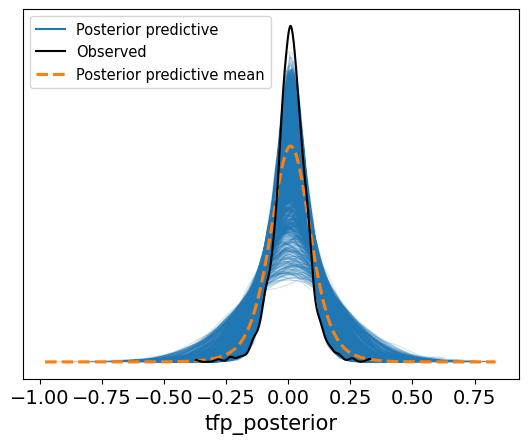

In [28]:
fig = az.plot_ppc(posterior,var_names=["tfp_posterior"]).figure
fig.show()

/tmp/ipykernel_118387/1930061569.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


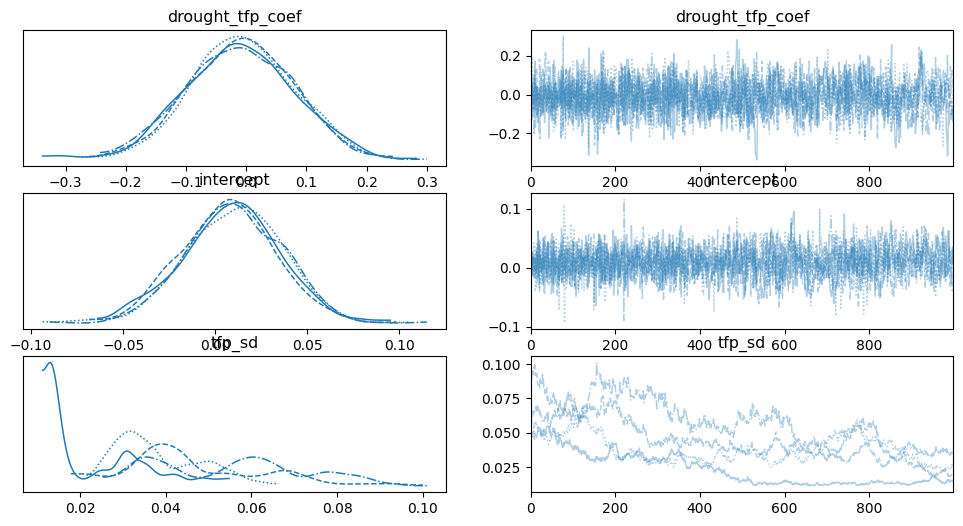

In [36]:
fig = az.plot_trace(trace, var_names=["drought_tfp_coef", "intercept", "tfp_sd"]).ravel()[0].figure
fig.show()

# create dataset

In [41]:
integrated_data_dict = {
    "country":[],
    "year":[],
    "drought":[],
    "extreme_temperature":[],
    "flood":[],
    "ln_GDP_change":[],
    "ln_TFP_change":[]
}

burke_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
ortizbobea_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_preferred_case.csv")
extreme_weather_data = pd.read_csv("../data/global_data/extreme_weather_events.csv")

all_countries = sorted((set(ortizbobea_data["ISO3"]).union(set(burke_data["iso"]))).intersection(set(extreme_weather_data["ISO"])))
all_years = sorted(set(ortizbobea_data["year"]).union(set(burke_data["year"])).union(set([int(year.split("-")[0]) for year in extreme_weather_data["DisNo."]])))

for index, country in enumerate(list(all_countries)):
    for year in all_years:
        burke_row = burke_data.loc[(burke_data["iso"] == country) & (burke_data["year"] == year)]
        ob_row = ortizbobea_data.loc[(ortizbobea_data["ISO3"] == country) & (ortizbobea_data["year"] == year)]
        ew_rows = extreme_weather_data.loc[(extreme_weather_data["DisNo."].str.startswith(str(year), na=False)) & (extreme_weather_data["ISO"] == country)]
        integrated_data_dict["country"].append(country)
        integrated_data_dict["year"].append(year)
        try:
            integrated_data_dict["ln_TFP_change"].append(ob_row["fd_log_tfp"].item())
        except ValueError:
            integrated_data_dict["ln_TFP_change"].append(np.NaN)
        try:
            integrated_data_dict["ln_GDP_change"].append(burke_row["growthWDI"].item())
        except ValueError:
            integrated_data_dict["ln_GDP_change"].append(np.NaN)
        for disaster_type in ["Flood","Drought","Extreme temperature"]:
            if len(ew_rows) == 0:
                integrated_data_dict[disaster_type.lower().replace(" ","_")].append(0)
            else:
                if any(ew_row["Disaster Type"] == disaster_type for _, ew_row in ew_rows.iterrows()):
                    integrated_data_dict[disaster_type.lower().replace(" ","_")].append(1)
                else:
                    integrated_data_dict[disaster_type.lower().replace(" ","_")].append(0)
pd.DataFrame.from_dict(integrated_data_dict).to_csv("../data/processed/drought-agtfp-gdp-data.csv", index=False)    